**Problem Set #3**

Computational Electromagnetism and Applications (ΥΦΥ203)

Implemented by: **Anastasios-Faidon Retselis (AEM: 4394)**

# Exercise 3.1

Write a code that implements the one dimension wave equation using the FDTD methods. Utilize first order Mur boundary conditions for the start and the end of the computational grid. At the left, insert a TFSF interface (Total Field Scattered Field). The wave must propagate to the right and come into contact with a material which extents till the end of the computational grid. The material shall have a relative permittivity $\epsilon_r$ and electrical conductivity $\sigma$ (S/m). Utilize a non-uniform grid around the interface of free space and the material. 

## Part 1

### Problem statement 

Show that the implementation of the TFSF interface is correct. 

### Solution

The following code is used (Python) for the implementation. It produces an .mp4 movie which can be used to visualize the Electric Field and validate the TFSF interface.

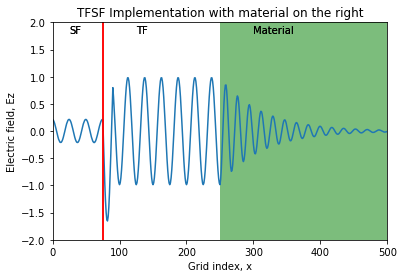

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# Silent run
import warnings
warnings.filterwarnings('ignore')
# Make plots pretty
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')


def source(omega, t):
    tw = pow(10, -10)
    t0 = tw * 10
    if t <= t0:
        return 2*np.sin(omega * t) * np.exp(-pow(t - t0, 2) / pow(tw, 2))
    else:
        return 2*np.sin(omega * t)

# Constants
c = 3 * pow(10, 8)
mu_0 = 4 * np.pi * pow(10, -7)
epsilon_0 = 1 / (pow(c, 2) * mu_0)

# Source definition
frequency = pow(10, 9)
T = 1 / frequency
lambda_source = c / frequency
omega = 2 * np.pi * frequency
source_location = 90

# Grid
size = 500
dx = lambda_source/25
grid_start = 0
grid_end = size - 1
TFSF_location = 75

# Time
N_periods = 30
S = 0.99
dt = S * dx / c
t_max = round(N_periods * T / dt)

# Material definition, ranging from [position, infinity)

material_location = 250
sigma_mat = 0.01
epsilon_r = 2
mu_r = 1
eaf = dt * sigma_mat/(2*epsilon_0*epsilon_r)
c_r = c/np.sqrt(epsilon_r*mu_r)

# Add and initialize electric and magnetic field
Hy = np.zeros(size)
Ez = np.zeros(size)
Ez_inc = np.zeros(size)
Hy_inc = np.zeros(size)
Ez_recording = np.zeros((t_max, size))
Hy_recording = np.zeros((t_max, size))

# Advance time
H_const_free_space = dt / (mu_0 * dx)
E_const_free_space = dt / (epsilon_0 * dx)


for j in range(0, t_max):

    # Record inc fields
    for i in range(0, size - 1):
        Hy_inc[i] = Hy_inc[i] - H_const_free_space * (Ez_inc[i+1] - Ez_inc[i])
    for i in range(1, size):
        Ez_inc[i] = Ez_inc[i] - E_const_free_space * (Hy_inc[i] - Hy_inc[i - 1])

    # Update magnetic field
    for i in range(0, size - 1):
        if i < material_location:
            Hy[i] = Hy[i] - H_const_free_space * (Ez[i + 1] - Ez[i])
        else:
            Hy[i] = Hy[i] - (dt / (mu_0 * mu_r * dx)) * (Ez[i + 1] - Ez[i])

    # Update electric field
    for i in range(1, size):
        if i < material_location:
            Ez[i] = Ez[i] - E_const_free_space * (Hy[i] - Hy[i - 1])
        else:
            Ez[i] = ((1-eaf)/(1+eaf))*Ez[i] - (dt / (epsilon_0*epsilon_r * dx*(1+eaf))) * (Hy[i] - Hy[i - 1])

    # Hardwire a source
    Ez[source_location] = Ez[source_location] + source(omega, j * dt)
    Ez_inc[source_location] = Ez_inc[source_location] + source(omega, j * dt)
    # Update TFSF boundaries
    Hy[TFSF_location] = Hy[TFSF_location] + H_const_free_space * Ez_inc[TFSF_location + 1]
    Ez[TFSF_location + 1] = Ez[TFSF_location + 1] + E_const_free_space * Hy_inc[TFSF_location]

    # Mur absorving boundary conditions
    if j > 2:
        Ez[grid_end] = Ez_secondtolast_prev + ((c_r * dt - dx) / (c_r * dt + dx)) * (Ez[grid_end - 1] - Ez_end_prev)
        Ez[grid_start] = Ez_1_prev + ((c * dt - dx) / (c * dt + dx)) * (Ez[1] - Ez_0_prev)

    Ez_0_prev = Ez[0]
    Ez_1_prev = Ez[1]
    Ez_end_prev = Ez[grid_end]
    Ez_secondtolast_prev = Ez[grid_end - 1]

    # Record Ez & Hy
    Ez_recording[j][:] = Ez
    Hy_recording[j][:] = Hy

# Prepare to create the movie    
fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [])


def init():
    ax.set_xlim(0, size)
    #ax.set_ylim(-4 * pow(10,-3), 4 * pow(10,-3))
    ax.set_ylim(-2, 2)
    ax.grid()
    ax.axvline(TFSF_location, color='red')
    ax.set_title("TFSF Implementation with material on the right")
    ax.set_xlabel("Grid index, x")
    ax.set_ylabel("Electric field, Ez")
    ax.text((TFSF_location-50), 1.8, 'SF')
    ax.text((TFSF_location + 50), 1.8, 'TF')
    ax.text((material_location + 50), 1.8, 'Material')
    ax.axvspan(material_location, size, facecolor='green', alpha=0.3)
    return ln,


def update(frame):
    xdata = np.arange(0, size, 1)
    ydata = Ez_recording[frame][:]
    ln.set_data(xdata, ydata)
    return ln,


ani = animation.FuncAnimation(fig, update, frames=t_max,
                              init_func=init, interval=1)
writer=animation.writers['ffmpeg'](fps=25)
plt.ioff()
dpi = 500
ani.save('TFSF_implementation_retselis.mp4',writer=writer,dpi=dpi)

From the attached movie (see **TFSF\_implementation\_retselis.mp4**) we can validate that the TFSF interface works. Initially, we observe no Electric Field in the left region which corresponds to the scattered field observation area. After the wave comes in contact with the material, we note the Total Field changes and after a while the reflected wave reaches the TFSF interface and starts to appear on the scattered field observation area. 

## Part 2

### Problem statement 

Show that the implementation of the boundary conditions is correct. 

### Solution

To show that the implementation create is correct, we can utilize the movie created for the first part. In the movie, we can see that for both boundary conditions no reflected wave appears, meaning that the boundary conditions perform nominally and absorb the incoming wave. 

## Part 3

### Problem statement 

Calculate and compare the numerical and analytical value for the reflection coefficient of the planar wave at the interface between the free space and the material, assuming different values for $\epsilon_r$.

### Solution

The reflection coefficient is given by the following formula (assuming that the first material is free space):

$$
R=\left[\frac{n_{1}-n_{2}}{n_{1}+n_{2}}\right]^{2}
$$

where $n_{1}=1$ (free space) and $n_{2}=\sqrt{\epsilon_{r}}$. Numerically, we can compute the reflection coefficient as:

$$
R=\left(\frac{E_{reflected}}{E_{incident}}\right)^{2}
$$

We will run the code above for several different values of $\epsilon_{r}$ and compare the results in a diagram.

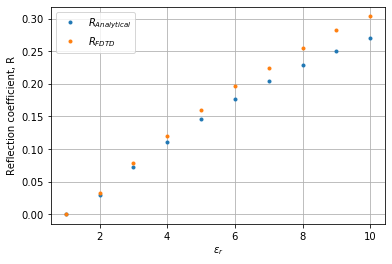

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Silent run
import warnings
warnings.filterwarnings('ignore')
# Make plots pretty
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')


def source(omega, t):
    tw = pow(10, -10)
    t0 = tw * 10
    if t <= t0:
        return 2*np.sin(omega * t) * np.exp(-pow(t - t0, 2) / pow(tw, 2))
    else:
        return 2*np.sin(omega * t)

def reclected_electric_field_calculator(epsilon_r):
    # Constants
    c = 3 * pow(10, 8)
    mu_0 = 4 * np.pi * pow(10, -7)
    epsilon_0 = 1 / (pow(c, 2) * mu_0)

    # Source definition
    frequency = pow(10, 9)
    T = 1 / frequency
    lambda_source = c / frequency
    omega = 2 * np.pi * frequency
    source_location = 90

    # Grid
    size = 500
    dx = lambda_source/25
    grid_start = 0
    grid_end = size - 1
    TFSF_location = 75

    # Time
    N_periods = 20
    S = 0.99
    dt = S * dx / c
    t_max = round(N_periods * T / dt)

    # Material definition, ranging from [position, infinity)

    material_location = 250
    sigma_mat = 0
    mu_r = 1
    eaf = dt * sigma_mat/(2*epsilon_0*epsilon_r)
    c_r = c/np.sqrt(epsilon_r*mu_r)

    # Add and initialize electric and magnetic field
    Hy = np.zeros(size)
    Ez = np.zeros(size)
    Ez_inc = np.zeros(size)
    Hy_inc = np.zeros(size)
    Ez_recording = np.zeros((t_max, size))
    Hy_recording = np.zeros((t_max, size))

    # Advance time
    H_const_free_space = dt / (mu_0 * dx)
    E_const_free_space = dt / (epsilon_0 * dx)


    for j in range(0, t_max):

        # Record inc fields
        for i in range(0, size - 1):
            Hy_inc[i] = Hy_inc[i] - H_const_free_space * (Ez_inc[i+1] - Ez_inc[i])
        for i in range(1, size):
            Ez_inc[i] = Ez_inc[i] - E_const_free_space * (Hy_inc[i] - Hy_inc[i - 1])

        # Update magnetic field
        for i in range(0, size - 1):
            if i < material_location:
                Hy[i] = Hy[i] - H_const_free_space * (Ez[i + 1] - Ez[i])
            else:
                Hy[i] = Hy[i] - (dt / (mu_0 * mu_r * dx)) * (Ez[i + 1] - Ez[i])

        # Update electric field
        for i in range(1, size):
            if i < material_location:
                Ez[i] = Ez[i] - E_const_free_space * (Hy[i] - Hy[i - 1])
            else:
                Ez[i] = ((1-eaf)/(1+eaf))*Ez[i] - (dt / (epsilon_0*epsilon_r * dx*(1+eaf))) * (Hy[i] - Hy[i - 1])

        # Hardwire a source
        Ez[source_location] = Ez[source_location] + source(omega, j * dt)
        Ez_inc[source_location] = Ez_inc[source_location] + source(omega, j * dt)
        # Update TFSF boundaries
        Hy[TFSF_location] = Hy[TFSF_location] + H_const_free_space * Ez_inc[TFSF_location + 1]
        Ez[TFSF_location + 1] = Ez[TFSF_location + 1] + E_const_free_space * Hy_inc[TFSF_location]

        # Mur absorving boundary conditions
        if j > 2:
            Ez[grid_end] = Ez_secondtolast_prev + ((c_r * dt - dx) / (c_r * dt + dx)) * (Ez[grid_end - 1] - Ez_end_prev)
            Ez[grid_start] = Ez_1_prev + ((c * dt - dx) / (c * dt + dx)) * (Ez[1] - Ez_0_prev)

        Ez_0_prev = Ez[0]
        Ez_1_prev = Ez[1]
        Ez_end_prev = Ez[grid_end]
        Ez_secondtolast_prev = Ez[grid_end - 1]

        # Record Ez & Hy
        Ez_recording[j][:] = Ez
        Hy_recording[j][:] = Hy
    E_reflected = np.amax(Ez_recording[:, 2])
    E_incident = np.amax(Ez_recording[0:105,100])
    return E_reflected, E_incident


e_r_values = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
R_analytical = np.zeros(10)
R_numerical = np.zeros(10)

for i in range(0, 10):
    current_e_r = e_r_values[i]
    x, y = reclected_electric_field_calculator(current_e_r)
    R_numerical[i] = pow(x/y, 2)
    R_analytical[i] = pow((1-np.sqrt(current_e_r))/(1+np.sqrt(current_e_r)), 2)

plt.figure()
plt.plot(e_r_values, R_analytical, '.', label=r'$R_{Analytical}$')
plt.plot(e_r_values, R_numerical, '.', label=r'$R_{FDTD}$')
plt.grid()
plt.legend()
plt.xlabel(r'$\epsilon_{r}$')
plt.ylabel('Reflection coefficient, R')
plt.show()

We can determine that the FDTD method produces an accurate result for the reflection coefficient, and that the error between the analytical and the numerical value of the reflection coefficient rises as $\epsilon_{r}$ becomes bigger. 

## Part 4

### Problem statement 

Determine the wavelength in free space and inside the material both numerically and analytically for all of the values of $\epsilon_{r}$ chosen above.

### Solution

For the wavelength of a wave inside a material:

$$
\lambda = \frac{\lambda_{o}}{n}
$$

where $\lambda_{o}$ is the wavelength in vacuum and $n=\sqrt{\epsilon_{r}}$ is the refractive index, while in vacuum, the wavelength is given by:

$$
\lambda = \frac{c}{f}
$$

Numerically, we can compute the wavelength as the distance between two peaks of the wave. 

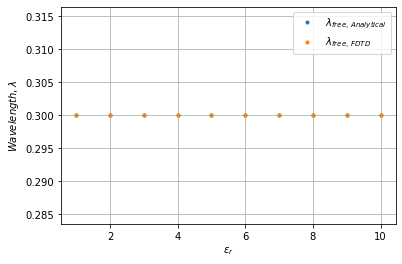

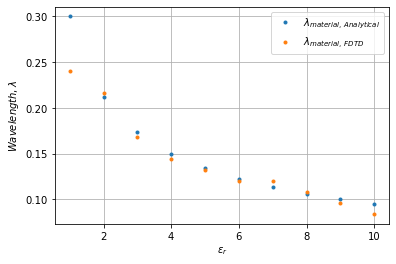

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# Silent run
import warnings
warnings.filterwarnings('ignore')
# Make plots pretty
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')


def source(omega, t):
    tw = pow(10, -10)
    t0 = tw * 10
    if t <= t0:
        return 2*np.sin(omega * t) * np.exp(-pow(t - t0, 2) / pow(tw, 2))
    else:
        return 2*np.sin(omega * t)

def reclected_electric_field_calculator(epsilon_r):
    # Constants
    c = 3 * pow(10, 8)
    mu_0 = 4 * np.pi * pow(10, -7)
    epsilon_0 = 1 / (pow(c, 2) * mu_0)

    # Source definition
    frequency = pow(10, 9)
    T = 1 / frequency
    lambda_source = c / frequency
    omega = 2 * np.pi * frequency
    source_location = 90

    # Grid
    size = 500
    dx = lambda_source/25
    grid_start = 0
    grid_end = size - 1
    TFSF_location = 75

    # Time
    N_periods = 20
    S = 0.99
    dt = S * dx / c
    t_max = round(N_periods * T / dt)

    # Material definition, ranging from [position, infinity)

    material_location = 250
    sigma_mat = 0.01
    mu_r = 1
    eaf = dt * sigma_mat/(2*epsilon_0*epsilon_r)
    c_r = c/np.sqrt(epsilon_r*mu_r)

    # Add and initialize electric and magnetic field
    Hy = np.zeros(size)
    Ez = np.zeros(size)
    Ez_inc = np.zeros(size)
    Hy_inc = np.zeros(size)
    Ez_recording = np.zeros((t_max, size))
    Hy_recording = np.zeros((t_max, size))

    # Advance time
    H_const_free_space = dt / (mu_0 * dx)
    E_const_free_space = dt / (epsilon_0 * dx)


    for j in range(0, t_max):

        # Record inc fields
        for i in range(0, size - 1):
            Hy_inc[i] = Hy_inc[i] - H_const_free_space * (Ez_inc[i+1] - Ez_inc[i])
        for i in range(1, size):
            Ez_inc[i] = Ez_inc[i] - E_const_free_space * (Hy_inc[i] - Hy_inc[i - 1])

        # Update magnetic field
        for i in range(0, size - 1):
            if i < material_location:
                Hy[i] = Hy[i] - H_const_free_space * (Ez[i + 1] - Ez[i])
            else:
                Hy[i] = Hy[i] - (dt / (mu_0 * mu_r * dx)) * (Ez[i + 1] - Ez[i])

        # Update electric field
        for i in range(1, size):
            if i < material_location:
                Ez[i] = Ez[i] - E_const_free_space * (Hy[i] - Hy[i - 1])
            else:
                Ez[i] = ((1-eaf)/(1+eaf))*Ez[i] - (dt / (epsilon_0*epsilon_r * dx*(1+eaf))) * (Hy[i] - Hy[i - 1])

        # Hardwire a source
        Ez[source_location] = Ez[source_location] + source(omega, j * dt)
        Ez_inc[source_location] = Ez_inc[source_location] + source(omega, j * dt)
        # Update TFSF boundaries
        Hy[TFSF_location] = Hy[TFSF_location] + H_const_free_space * Ez_inc[TFSF_location + 1]
        Ez[TFSF_location + 1] = Ez[TFSF_location + 1] + E_const_free_space * Hy_inc[TFSF_location]

        # Mur absorving boundary conditions
        if j > 2:
            Ez[grid_end] = Ez_secondtolast_prev + ((c_r * dt - dx) / (c_r * dt + dx)) * (Ez[grid_end - 1] - Ez_end_prev)
            Ez[grid_start] = Ez_1_prev + ((c * dt - dx) / (c * dt + dx)) * (Ez[1] - Ez_0_prev)

        Ez_0_prev = Ez[0]
        Ez_1_prev = Ez[1]
        Ez_end_prev = Ez[grid_end]
        Ez_secondtolast_prev = Ez[grid_end - 1]

        # Record Ez & Hy
        Ez_recording[j][:] = Ez
        Hy_recording[j][:] = Hy
    index = np.argmax(Ez_recording[0:150, 148])
    index_2 = np.argmax(Ez_recording[index,100:140])
    lam_vac_num = (148-100-index_2)*dx
    if epsilon_r ==1:
        index = np.argmax(Ez_recording[0:350, 295])
        index_2 = np.argmax(Ez_recording[index,275:285])  
        lam_mat_num = (295-275-index_2)*dx
    elif epsilon_r < 6:
        index = np.argmax(Ez_recording[0:350, 295])
        index_2 = np.argmax(Ez_recording[index,275:285])  
        lam_mat_num = (295-275-index_2)*dx
    elif epsilon_r < 10:
        index = np.argmax(Ez_recording[0:350, 295])
        index_2 = np.argmax(Ez_recording[index,280:290])  
        lam_mat_num = (295-280-index_2)*dx
    else:
        index = np.argmax(Ez_recording[0:350, 295])
        index_2 = np.argmax(Ez_recording[index,285:290])  
        lam_mat_num = (295-285-index_2)*(dx)
    return lambda_source, lam_vac_num, lam_mat_num


e_r_values = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
lambda_vac_analytical = np.zeros(10)
lambda_vac_numerical = np.zeros(10)
lambda_mat_analytical = np.zeros(10)
lambda_mat_numerical = np.zeros(10)

for i in range(0, 10):
    current_e_r = e_r_values[i]
    lambda_vac_analytical[i], lambda_vac_numerical[i], lambda_mat_numerical[i] = reclected_electric_field_calculator(current_e_r)
    lambda_mat_analytical[i] = lambda_vac_analytical[i]/np.sqrt(current_e_r)

plt.figure()
plt.plot(e_r_values, lambda_vac_analytical, '.', label=r'$\lambda_{free,\:Analytical}$')
plt.plot(e_r_values, lambda_vac_numerical, '.', label=r'$\lambda_{free,\:FDTD}$')
plt.grid()
plt.legend()
plt.xlabel(r'$\epsilon_{r}$')
plt.ylabel(r'$Wave length, \lambda$')
plt.show()

plt.figure()
plt.plot(e_r_values, lambda_mat_analytical, '.', label=r'$\lambda_{material,\:Analytical}$')
plt.plot(e_r_values, lambda_mat_numerical, '.', label=r'$\lambda_{material,\:FDTD}$')
plt.grid()
plt.legend()
plt.xlabel(r'$\epsilon_{r}$')
plt.ylabel(r'$Wave length, \lambda$')
plt.show()

We note that the wavelength in free space is identical for the analytical and the numerical case, while there is a small error on the wavelength inside the material. In any case, we can observe that the trend is being followed. 

## Part 5

### Problem statement 

While maintaining a constant frequency, show how the penetration length changes inside the material with respect to the electrical conductivity.

### Solution

Penetration depth is given by the formula:

$$
\delta=\sqrt{\frac{2}{\omega \mu \sigma}}
$$

To find the penetration depth numerically, we plot one frame with the wave propagating inside the material and we can determine via the definition the x-value for which the electric field has dropped to $1/\epsilon$.

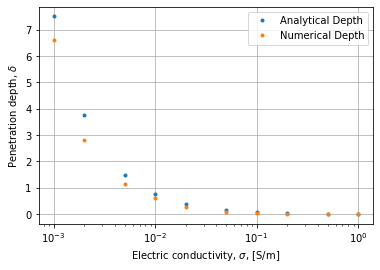

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# Silent run
import warnings
warnings.filterwarnings('ignore')
# Make plots pretty
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')


def source(omega, t):
    tw = pow(10, -10)
    t0 = tw * 10
    if t <= t0:
        return 2*np.sin(omega * t) * np.exp(-pow(t - t0, 2) / pow(tw, 2))
    else:
        return 2*np.sin(omega * t)

def reclected_electric_field_calculator(sigma_mat):
    # Constants
    c = 3 * pow(10, 8)
    mu_0 = 4 * np.pi * pow(10, -7)
    epsilon_0 = 1 / (pow(c, 2) * mu_0)

    # Source definition
    frequency = pow(10, 9)
    T = 1 / frequency
    lambda_source = c / frequency
    omega = 2 * np.pi * frequency
    source_location = 90

    # Grid
    size = 500
    dx = lambda_source/25
    grid_start = 0
    grid_end = size - 1
    TFSF_location = 75

    # Time
    N_periods = 20
    S = 0.99
    dt = S * dx / c
    t_max = round(N_periods * T / dt)

    # Material definition, ranging from [position, infinity)

    material_location = 250
    mu_r = 1
    epsilon_r = 2
    eaf = dt * sigma_mat/(2*epsilon_0*epsilon_r)
    c_r = c/np.sqrt(epsilon_r*mu_r)

    # Add and initialize electric and magnetic field
    Hy = np.zeros(size)
    Ez = np.zeros(size)
    Ez_inc = np.zeros(size)
    Hy_inc = np.zeros(size)
    Ez_recording = np.zeros((t_max, size))
    Hy_recording = np.zeros((t_max, size))

    # Advance time
    H_const_free_space = dt / (mu_0 * dx)
    E_const_free_space = dt / (epsilon_0 * dx)


    for j in range(0, t_max):

        # Record inc fields
        for i in range(0, size - 1):
            Hy_inc[i] = Hy_inc[i] - H_const_free_space * (Ez_inc[i+1] - Ez_inc[i])
        for i in range(1, size):
            Ez_inc[i] = Ez_inc[i] - E_const_free_space * (Hy_inc[i] - Hy_inc[i - 1])

        # Update magnetic field
        for i in range(0, size - 1):
            if i < material_location:
                Hy[i] = Hy[i] - H_const_free_space * (Ez[i + 1] - Ez[i])
            else:
                Hy[i] = Hy[i] - (dt / (mu_0 * mu_r * dx)) * (Ez[i + 1] - Ez[i])

        # Update electric field
        for i in range(1, size):
            if i < material_location:
                Ez[i] = Ez[i] - E_const_free_space * (Hy[i] - Hy[i - 1])
            else:
                Ez[i] = ((1-eaf)/(1+eaf))*Ez[i] - (dt / (epsilon_0*epsilon_r * dx*(1+eaf))) * (Hy[i] - Hy[i - 1])

        # Hardwire a source
        Ez[source_location] = Ez[source_location] + source(omega, j * dt)
        Ez_inc[source_location] = Ez_inc[source_location] + source(omega, j * dt)
        # Update TFSF boundaries
        Hy[TFSF_location] = Hy[TFSF_location] + H_const_free_space * Ez_inc[TFSF_location + 1]
        Ez[TFSF_location + 1] = Ez[TFSF_location + 1] + E_const_free_space * Hy_inc[TFSF_location]

        # Mur absorving boundary conditions
        if j > 2:
            Ez[grid_end] = Ez_secondtolast_prev + ((c_r * dt - dx) / (c_r * dt + dx)) * (Ez[grid_end - 1] - Ez_end_prev)
            Ez[grid_start] = Ez_1_prev + ((c * dt - dx) / (c * dt + dx)) * (Ez[1] - Ez_0_prev)

        Ez_0_prev = Ez[0]
        Ez_1_prev = Ez[1]
        Ez_end_prev = Ez[grid_end]
        Ez_secondtolast_prev = Ez[grid_end - 1]

        # Record Ez & Hy
        Ez_recording[j][:] = Ez
        Hy_recording[j][:] = Hy
    outcome = (2/sigma_mat)*np.sqrt((epsilon_0*epsilon_r)/(mu_0 *mu_r))
    return Ez_recording[t_max-1, :], outcome
        
sigma_values = np.array([0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1])
depth_numerical = np.array([6.592, 2.832, 1.14, 0.632, 0.26, 0.065, 0.035, 0.022, 0.008, 0.003])
depth_analytical = np.zeros(10)
for i in range(0, 10):
    result, depth_analytical[i] = reclected_electric_field_calculator(sigma_values[i])

plt.figure()
plt.semilogx(sigma_values, depth_analytical, '.', label='Analytical Depth')
plt.semilogx(sigma_values, depth_numerical, '.',label='Numerical Depth')
plt.xlabel(r'Electric conductivity, $\sigma$, [S/m]')
plt.ylabel(r'Penetration depth, $\delta$')
plt.legend()
plt.grid()
plt.show()

We note that the wavelength in free space is identical for the analytical and the numerical case, while there is a small error on the wavelength inside the material. In any case, we can observe that the trend is being followed. 

## Part 6

### Problem statement 

While maintaining a constant electrical conductivity for the material, show how the penetration length changes inside the material with respect to the frequency.

### Solution

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Silent run
import warnings
warnings.filterwarnings('ignore')
# Make plots pretty
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')


def source(omega, t):
    tw = pow(10, -10)
    t0 = tw * 10
    if t <= t0:
        return 2*np.sin(omega * t) * np.exp(-pow(t - t0, 2) / pow(tw, 2))
    else:
        return 2*np.sin(omega * t)

def reclected_electric_field_calculator(frequency):
    # Constants
    c = 3 * pow(10, 8)
    mu_0 = 4 * np.pi * pow(10, -7)
    epsilon_0 = 1 / (pow(c, 2) * mu_0)

    # Source definition
    #frequency = pow(10, 9)
    T = 1 / frequency
    lambda_source = c / frequency
    omega = 2 * np.pi * frequency
    source_location = 90

    # Grid
    size = 500
    dx = lambda_source/25
    grid_start = 0
    grid_end = size - 1
    TFSF_location = 75

    # Time
    N_periods = 20
    S = 0.99
    dt = S * dx / c
    t_max = int (N_periods * T / dt)

    # Material definition, ranging from [position, infinity)

    material_location = 250
    sigma_mat = 0.01
    mu_r = 1
    epsilon_r = 2
    eaf = dt * sigma_mat/(2*epsilon_0*epsilon_r)
    c_r = c/np.sqrt(epsilon_r*mu_r)

    # Add and initialize electric and magnetic field
    Hy = np.zeros(size)
    Ez = np.zeros(size)
    Ez_inc = np.zeros(size)
    Hy_inc = np.zeros(size)
    Ez_recording = np.zeros((t_max, size))
    Hy_recording = np.zeros((t_max, size))

    # Advance time
    H_const_free_space = dt / (mu_0 * dx)
    E_const_free_space = dt / (epsilon_0 * dx)


    for j in range(0, t_max):

        # Record inc fields
        for i in range(0, size - 1):
            Hy_inc[i] = Hy_inc[i] - H_const_free_space * (Ez_inc[i+1] - Ez_inc[i])
        for i in range(1, size):
            Ez_inc[i] = Ez_inc[i] - E_const_free_space * (Hy_inc[i] - Hy_inc[i - 1])

        # Update magnetic field
        for i in range(0, size - 1):
            if i < material_location:
                Hy[i] = Hy[i] - H_const_free_space * (Ez[i + 1] - Ez[i])
            else:
                Hy[i] = Hy[i] - (dt / (mu_0 * mu_r * dx)) * (Ez[i + 1] - Ez[i])

        # Update electric field
        for i in range(1, size):
            if i < material_location:
                Ez[i] = Ez[i] - E_const_free_space * (Hy[i] - Hy[i - 1])
            else:
                Ez[i] = ((1-eaf)/(1+eaf))*Ez[i] - (dt / (epsilon_0*epsilon_r * dx*(1+eaf))) * (Hy[i] - Hy[i - 1])

        # Hardwire a source
        Ez[source_location] = Ez[source_location] + source(omega, j * dt)
        Ez_inc[source_location] = Ez_inc[source_location] + source(omega, j * dt)
        # Update TFSF boundaries
        Hy[TFSF_location] = Hy[TFSF_location] + H_const_free_space * Ez_inc[TFSF_location + 1]
        Ez[TFSF_location + 1] = Ez[TFSF_location + 1] + E_const_free_space * Hy_inc[TFSF_location]

        # Mur absorving boundary conditions
        if j > 2:
            Ez[grid_end] = Ez_secondtolast_prev + ((c_r * dt - dx) / (c_r * dt + dx)) * (Ez[grid_end - 1] - Ez_end_prev)
            Ez[grid_start] = Ez_1_prev + ((c * dt - dx) / (c * dt + dx)) * (Ez[1] - Ez_0_prev)

        Ez_0_prev = Ez[0]
        Ez_1_prev = Ez[1]
        Ez_end_prev = Ez[grid_end]
        Ez_secondtolast_prev = Ez[grid_end - 1]

        # Record Ez & Hy
        Ez_recording[j][:] = Ez
        Hy_recording[j][:] = Hy
    outcome = np.sqrt(1/(np.pi*(frequency/epsilon_r)*mu_0*mu_r*sigma_mat))
    return outcome
        
freq_values = np.array([pow(10, 9), 2*pow(10, 9), 3*pow(10, 9), 4*pow(10, 9), 5*pow(10, 9), 6*pow(10, 9), 7*pow(10, 9), 8*pow(10, 9), 9*pow(10, 9), 10*pow(10, 9)])
depth_numerical = np.array([0.72, 0.682, 0.65, 0.682, 0.7, 0.65, 0.72, 0.68, 0.7, 0.68])
depth_analytical = np.zeros(10)
for i in range(0, 10):
    depth_analytical[i] = reclected_electric_field_calculator(freq_values[i])

plt.figure()
plt.semilogx(freq_values, depth_analytical, '.', label='Analytical Depth')
plt.semilogx(freq_values, depth_numerical, '.',label='Numerical Depth')
plt.xlabel(r'Frequency, $f$, [Hz]')
plt.ylabel(r'Penetration depth, $\delta$')
plt.legend()
plt.grid()
plt.show()

We note that for the elected frequencies it does not appear that the numerical value follows the corresponding analytical formula. This happens because we have chosen very high frequencies (higher than $\sigma/\epsilon$ in which case the skin depth asymptotically approaches the value:

$$
\delta \approx \frac{2}{\sigma} \sqrt{\frac{\varepsilon}{\mu}}
$$

which in this case is equal to $\delta=0.75$, which is close to the value returned by the numerical simulation, indicating that our simulation performs nominally.